<a href="https://colab.research.google.com/github/ttknguyen/CS114.L22.KHCL/blob/master/BaiTapColab/Bai4sarcasmClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><b>CS114.L21 - MÁY HỌC - MACHINE LEARNING</b></h1>
<h1 align="center"><b>BÀI TẬP COLAB SỐ 04: Crawl Data</b></h1>

**Nhóm thực hiệ**n:
- Thái Trần Khánh Nguyên - 19520188
- Nguyễn Khánh Như - 19520209
- Đoàn Nguyễn Nhật Quang - 19520235

# Import Necessary Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
import json
import nltk
from google.colab import drive
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import gensim
from gensim.models import Word2Vec
from keras.preprocessing import text, sequence

# Loading Dataset from Drive

In [39]:
drive.mount('/gdrive')
path = '/gdrive/MyDrive/MachineLearning/CS114.L22.KHCL/DataSetColab4/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [40]:
listfile = ['BabylonBee', 'Chaser', 'NBCNews', 'TheBeaverton', 'TheGuardian', 'TheSun']

In [41]:
def loadData():
  dt = []
  for fileName in listfile:
    tweets_data = []
    tweet_file = open(path + fileName + '.json', "rb")
    for line in tweet_file:
      try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
      except:
        continue   
    tweet_file.close()
    tweet_info = pd.DataFrame()
    tweet_info['is_sarcastic'] = list(map(lambda tweet: tweet['is_sarcastic'], tweets_data))
    tweet_info['headline'] = list(map(lambda tweet: tweet['headline'], tweets_data))
    tweet_info['article_link'] = list(map(lambda tweet: tweet['article_link'], tweets_data))
    tweet_info.head(10)
    dt.append(tweet_info)
  return pd.concat([dt[0],dt[1],dt[2],dt[3],dt[4],dt[5]], ignore_index=True)

dataset = loadData()

In [42]:
dataset

,is_sarcastic,headline,article_link
0,1,Toobin Reinstated In Touching Interview: I Got...,https://babylonbee.com//news/toobin-gets-off-easy
1,1,Joel Osteen: Attacks Against Me Are Attacks Ag...,https://babylonbee.com//news/osteen-an-attack-...
2,1,CNN Forced To Reset Days Since Trump Was Prove...,https://babylonbee.com//news/cnn-forced-to-res...
3,1,"Biden: If You Dont Use The N-Word, You Aint My...",https://babylonbee.com//news/if-you-dont-use-t...
4,1,Pelosi Asks Omar To Clarify Ambiguous Statemen...,https://babylonbee.com//news/pelosi-asks-for-c...
...,...,...,...
94867,0,Ed Sheeran named baby Lyra after main characte...,https://www.thesun.co.uk/tvandshowbiz/12550137...
94868,0,Thousands to get soups & shakes diet on NHS pr...,https://www.thesun.co.uk/news/12544929/thousan...
94869,0,Fuel duty may be hiked by 5p to pay for Covid ...,https://www.thesun.co.uk/news/12547092/fuel-du...
94870,0,"Three Brits detained after mum, 60, killed wit...",https://www.thesun.co.uk/news/12542321/brits-c...


In [43]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94872 entries, 0 to 94871
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  94872 non-null  int64 
 1   headline      94872 non-null  object
 2   article_link  94872 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


Text(0.5, 1.0, 'is_sarcastic value counts')

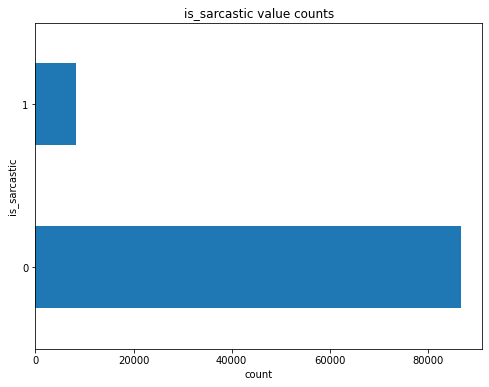

In [68]:
dataset['is_sarcastic'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("count")
plt.ylabel("is_sarcastic")
plt.title("is_sarcastic value counts")

Sau khi kiểm tra số lượng thì nhóm em thấy số lượng các bài báo châm biếm còn qúa ít nên nhóm em sẽ gom thêm dữ liệu về dạng này.

In [72]:
improve_data = pd.read_csv('https://raw.githubusercontent.com/vanviethieuanh/CS114.L21/main/News%20Scraping/19522054/news/data_1.csv')
dataset = pd.concat([dataset, improve_data], ignore_index=True)

In [100]:
tweets_data = []
tweet_file = open(path +  'dailymash.json', "rb")
for line in tweet_file:
  try:
    tweet = json.loads(line)
    tweets_data.append(tweet)
  except:
    continue   
tweet_file.close()
tweet_info = pd.DataFrame()
tweet_info['is_sarcastic'] = list(map(lambda tweet: tweet['is_sarcastic'], tweets_data))
tweet_info['headline'] = list(map(lambda tweet: tweet['headline'], tweets_data))
tweet_info['article_link'] = list(map(lambda tweet: tweet['article_link'], tweets_data))
tweet_info.head(10)

,is_sarcastic,headline,article_link
0,1,Drivers Who Shoot At People From Behind The Wh...,https://www.thedailymash.co.uk/news/society/dr...


Text(0.5, 1.0, 'is_sarcastic value counts')

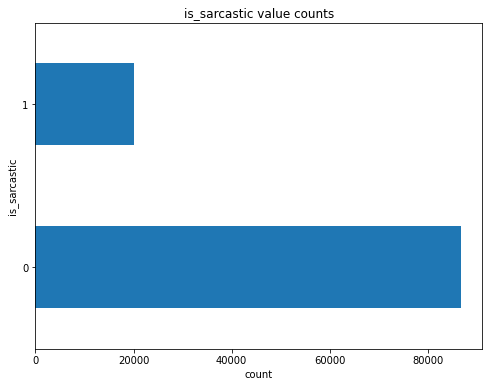

In [73]:
dataset['is_sarcastic'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("count")
plt.ylabel("is_sarcastic")
plt.title("is_sarcastic value counts")

# Preprocessing Data

## Lấy những thông tin cần thiết

Trong bài toán này thì chúng ta sử dụng tiêu đề (headline) của bài báo để dự đoán xem đấy là bài báo châm biếm hay không. Do không cần thiết sử dụng nội dung của bài báo nên mục article_link không sử dụng và sẽ được lược bỏ.

In [74]:
dataset = dataset[['is_sarcastic', 'headline']]
dataset

,is_sarcastic,headline
0,1,toobin reinstated touching interview got easy
1,1,joel osteen attacks attacks bible
2,1,cnn forced reset days since trump proven right...
3,1,biden dont use nword aint son
4,1,pelosi asks omar clarify ambiguous statement k...
...,...,...
106699,1,Distressed Fyre Festival Attendees on Beach Sp...
106700,1,Ninth Day of Tour Marks 15th Straight Day of T...
106701,1,Sickest Hardcore Venue in Town Also Open at 11...
106702,1,Punk on ‘Shark Tank’ Wants $25 to Make Some Pins


## Check NaN

Kiểm tra lại xem dự liệu đang dùng có những tập bị thiếu hay không.

In [75]:
dataset.isna().sum()

is_sarcastic    0
headline        0
dtype: int64

Và may mắn là không có trường hợp nào bị thiếu cả nên nhóm em tiếp tục thực hiện các bước tiền xử lý tiếp theo trước khi cho vào model.

## Lowercasing

Chuyển các chữ in hoa thành chữ thường

In [76]:
for index in range(dataset.shape[0]):
  dataset['headline'][index] = dataset['headline'][index].lower() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
dataset

,is_sarcastic,headline
0,1,toobin reinstated touching interview got easy
1,1,joel osteen attacks attacks bible
2,1,cnn forced reset days since trump proven right...
3,1,biden dont use nword aint son
4,1,pelosi asks omar clarify ambiguous statement k...
...,...,...
106699,1,distressed fyre festival attendees on beach sp...
106700,1,ninth day of tour marks 15th straight day of t...
106701,1,sickest hardcore venue in town also open at 11...
106702,1,punk on ‘shark tank’ wants $25 to make some pins


## Remove Special Character

Theo như nhóm em tìm hiểu thì chúng ta cần loại bỏ các ký tự đặc biệt như "! # $ % ..." để đưa vào các model như word2vec, ... vì những model ấy chỉ có những từ có nghĩa trong từ điển 

In [78]:
import string
input_str = "This &is [an] example? {of} string. with.? punctuation!!!!" # Sample string
result = input_str.translate(str.maketrans("","", string.punctuation))
print(result)

This is an example of string with punctuation


In [79]:
for index in range(dataset.shape[0]):
  dataset['headline'][index] = dataset['headline'][index].translate(str.maketrans("","", string.punctuation))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
dataset

,is_sarcastic,headline
0,1,toobin reinstated touching interview got easy
1,1,joel osteen attacks attacks bible
2,1,cnn forced reset days since trump proven right...
3,1,biden dont use nword aint son
4,1,pelosi asks omar clarify ambiguous statement k...
...,...,...
106699,1,distressed fyre festival attendees on beach sp...
106700,1,ninth day of tour marks 15th straight day of t...
106701,1,sickest hardcore venue in town also open at 11...
106702,1,punk on ‘shark tank’ wants 25 to make some pins


## Remove "\t"

In [81]:
for index in range(dataset.shape[0]):
  dataset['headline'][index] = dataset['headline'][index].strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
dataset

,is_sarcastic,headline
0,1,toobin reinstated touching interview got easy
1,1,joel osteen attacks attacks bible
2,1,cnn forced reset days since trump proven right...
3,1,biden dont use nword aint son
4,1,pelosi asks omar clarify ambiguous statement k...
...,...,...
106699,1,distressed fyre festival attendees on beach sp...
106700,1,ninth day of tour marks 15th straight day of t...
106701,1,sickest hardcore venue in town also open at 11...
106702,1,punk on ‘shark tank’ wants 25 to make some pins


## Remove Stopwords

Stopwords là những từ phổ biến nhất trong một ngôn ngữ như “the”, “a”, “on”, “is”, “all”. Những từ này không mang ý nghĩa quan trọng và thường bị xóa khỏi văn bản. Chính vì thế nhóm em sẽ loại bỏ bớt chúng trong tập dữ liệu

In [83]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [84]:
from nltk.corpus import stopwords
#Một số stopword trong tiếng anh
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [85]:
stop_words = set(stopwords.words("english"))
from nltk.tokenize import word_tokenize

In [86]:
def remove_stopwords(headline):
  word_token=word_tokenize(headline)
  clean_headline=[i for i in word_token if i not in stop_words]
  return ' '.join([str(elem) for elem in clean_headline])
dataset['headline'] = dataset['headline'].apply(remove_stopwords)

In [87]:
dataset

,is_sarcastic,headline
0,1,toobin reinstated touching interview got easy
1,1,joel osteen attacks attacks bible
2,1,cnn forced reset days since trump proven right...
3,1,biden dont use nword aint son
4,1,pelosi asks omar clarify ambiguous statement k...
...,...,...
106699,1,distressed fyre festival attendees beach spell...
106700,1,ninth day tour marks 15th straight day taco bell
106701,1,sickest hardcore venue town also open 11 sunda...
106702,1,punk ‘ shark tank ’ wants 25 make pins


# Train Model

## Split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(dataset['headline'],dataset['is_sarcastic'] , test_size=0.2, random_state=42)

## Create vocab

In [89]:
#tách các từ trong câu thành kiểu list trong data train
words = []
for i in X_train:
  words.append(i.split())

#tách các từ trong câu thành kiểu list trong data test
words_test = []
for i in X_test:
  words_test.append(i.split())
  words_test
#in ra demo 9 headlines đầu tiên
words[:5]

[['shirley',
  'knight',
  'oscarnominated',
  'actress',
  'sweet',
  'bird',
  'youth',
  'dies',
  '83'],
 ['vanessa', 'bryant', 'slams', 'lawsuit', 'mom', 'seeking', 'support'],
 ['band', 'set', 'big', 'screen', 'behind', 'pool', 'table'],
 ['part',
  'settlement',
  'nick',
  'sandmann',
  'cnn',
  'hosts',
  'must',
  'wear',
  'maga',
  'hats',
  'broadcasts'],
 ['sludge',
  'band',
  'would',
  'death',
  'metal',
  '’',
  'goddamn',
  'tired',
  'time']]

In [90]:
# Tạo ra model để tính toán mối quan hệ giữa các từ xuất hiện trong data_to_w2v
# size: kích thước vector biểu diễn cho một từ (size càng lớn thì càng phân biệt rõ sự khác nhau của một từ với các từ còn lại)
# window: số lượng từ lân cận của từ đang xét trong câu.
import gensim
from gensim.models import Word2Vec
model_w2v = gensim.models.Word2Vec(sentences = words, min_count = 1, size = 1, window = 5)

## Word2vec

In [91]:
len(model_w2v.wv.vocab)
num_voca = len(model_w2v.wv.vocab)

#vectơ hóa các từ, bằng cách chuyển thành một chuỗi các số nguyên trong trên data train
tokenizer = text.Tokenizer(num_voca)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
tokenized_test = tokenizer.texts_to_sequences(words_test)
_x_train = sequence.pad_sequences(tokenized_train, maxlen = 20)
_x_test = sequence.pad_sequences(tokenized_test, maxlen = 20)
vocab_size = len(tokenizer.word_index) + 1
#tạo trọng số cho ma trận vector của các từ
def get_matrix_weights(model, vocab):
  # như đã nói ở trên ta phải tăng kích thước của vocab_size lên 1 cho các từ chưa biết
  vocab_size = len(vocab) + 1
  weight = np.zeros((vocab_size, 1))
  for word, index in vocab.items():
    weight[index] = model[word]
  return weight

In [92]:
vocab_size = len(tokenizer.word_index) + 1
#tạo trọng số cho ma trận vector của các từ
def get_matrix_weights(model, vocab):
  # như đã nói ở trên ta phải tăng kích thước của vocab_size lên 1 cho các từ chưa biết
  vocab_size = len(vocab) + 1
  weight = np.zeros((vocab_size, 1))
  for word, index in vocab.items():
    weight[index] = model[word]
  return weight

In [93]:

  #tạo trọng số ma trận cho vector của các từ trong vocab
get_embbed_vector = get_matrix_weights(model_w2v, tokenizer.word_index)
token_word = text.Tokenizer(num_voca)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [94]:
_model_w2v = Sequential()
#thêm vào model các lớp layer chưa được đào tạo
_model_w2v.add(Embedding(vocab_size, output_dim=1, weights = [get_embbed_vector], input_length=20,trainable=True ))
#xây dựng mô hình LSTM cho model để train
_model_w2v.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
_model_w2v.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
_model_w2v.add(Dense(1, activation='sigmoid'))
_model_w2v.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del get_embbed_vector

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [95]:
_model_w2v.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 1)             43461     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 20, 256)           133120    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 232,326
Trainable params: 232,326
Non-trainable params: 0
_________________________________________________________________


In [96]:
print("Accuracy of the model on traning: " , _model_w2v.evaluate(_x_train,y_train)[1])


2668/2668 [==============================] - 49s 16ms/step - loss: 0.6134 - acc: 0.8118
Accuracy of the model on traning:  0.8117802739143372


In [97]:
print("Accuracy of the model on testing: " , _model_w2v.evaluate(_x_test,y_test)[1])


667/667 [==============================] - 10s 16ms/step - loss: 0.6117 - acc: 0.8151
Accuracy of the model on testing:  0.8150976896286011
